In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  
import scipy.io as sio
import sys,os
import scipy as sp
from scipy import signal
import pyxdf


sys.path.append('/Users/irawadee.t/Desktop/research 2022/data_analysis/final_analysis')

In [4]:
import matplotlib.cm as cm
def vline_markers(tMarkers,dataMarkers,ax = None):
    colors = iter(['b','r','c','g','k','m','y'])
    if ax == None:
        #colors = iter(cm.rainbow(np.linspace(0, 1, len(tMarkers)-len(np.where(dataMarkers==[99])))))
        for i in range(tMarkers.size):
            if dataMarkers[i][0] == 99:
                continue
            else:
                plt.axvline(tMarkers[i],ls = '--',color = next(colors))
    else:
        for i in range(tMarkers.size):
            if dataMarkers[i][0] == 99:
                continue
            else:
                ax.axvline(tMarkers[i],ls = '--',color = next(colors))

In [5]:

#data, header = pyxdf.load_xdf('./test_data/exp001/block_thisworks.xdf')

files = ['01_andrew.xdf',
        '03_maya.xdf', '04_benjamin.xdf']
data, header = pyxdf.load_xdf('/Users/irawadee.t/Desktop/research 2022/real_data/'+files[1])

In [6]:
devices = {}
dataEGG = None
dataEEG = None
tEGG = None
tEEG = None
fsEGG = 250
fsEEG = 250

for i in range(len(data)):
  print(data[i]['info']['source_id'])
  source_name = data[i]['info']['source_id'][0]

  if (source_name == 'Explore_8555_ExG') or (source_name == 'Explore_854F_ExG') :
    dataEEG = data[i]['time_series']
    tEEG = data[i]['time_stamps']
  if source_name[:11] == 'openbci_eeg':
    dataEGG = data[i]['time_series']
    tEGG = data[i]['time_stamps']
  if source_name == 'example_stream_001':
    dataMarkers = data[i]['time_series']
    tMarkers = data[i]['time_stamps']
  

'''
  key = data[i]['info']['source_id'][0][12:]
  if key not in devices:
    devices[key] = {}
  
  data_type = data[i]['info']['type'][0]
  if data_type == 'EEG':
    devices[key]['EEG'] = i
  elif data_type == 'AUX':
    devices[key]['AUX'] = i    
  #else:
    #print('check for new data type')
'''
print()

['Explore_854F_ORN']
['Explore_854F_Markers']
['Explore_854F_ExG']
['openbci_aux_id14']
['openbci_eeg_id14']
['example_stream_001']



In [7]:
devices.keys()

dict_keys([])

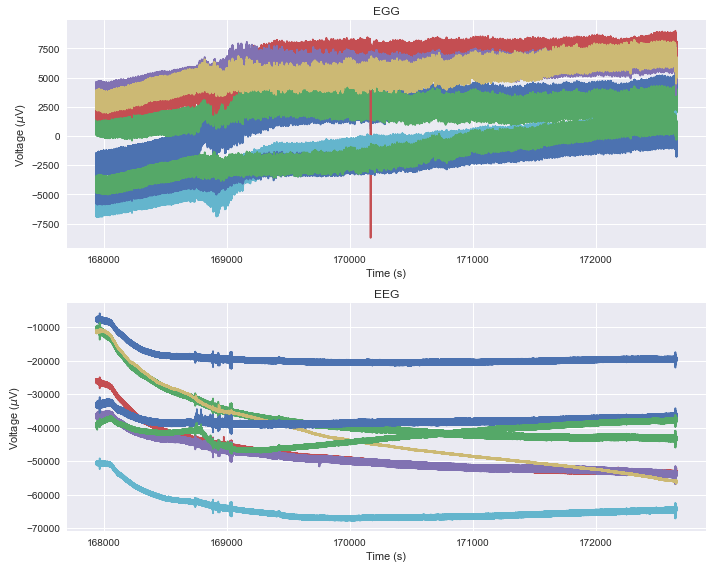

In [8]:
plt.style.use('seaborn')
plt.subplots(2,1,figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(tEGG,dataEGG)#[:,0])
plt.title('EGG')
plt.xlabel('Time (s)')
plt.ylabel(r'Voltage ($\mu$V)')
#plt.xlim([0,60])

plt.subplot(2,1,2)
plt.plot(tEEG,dataEEG)
plt.title('EEG')
plt.xlabel('Time (s)')
plt.ylabel(r'Voltage ($\mu$V)')

plt.tight_layout()
plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_1.png')

## EGG Processing

Text(0.5, 1.0, 'Post Notch Filter')

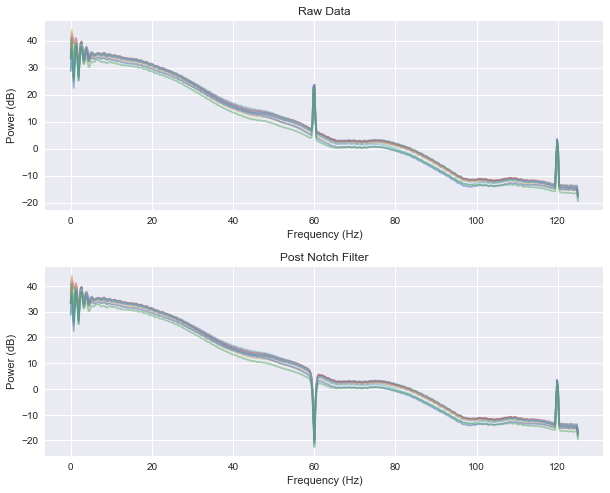

In [9]:
#f = np.linspace(0,fsEGG,dataEGG.shape[0],endpoint=False)
#plt.plot(f,20*np.log10(np.abs(np.fft.fft(dataEGG,axis = 0))),alpha = .5)
#plt.xlim([0,fsEGG/2])

plt.subplots(2,1,figsize = (10,8))
plt.subplots_adjust(hspace = 0.3)

plt.subplot(2,1,1)
for i in range(8):
  f,Pxx = sp.signal.welch(dataEGG[:,i],fs = fsEGG,nperseg=1024)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Raw Data')


plt.subplot(2,1,2)
sos = sp.signal.butter(2,[59.5,60.5],btype = 'bandstop',fs = fsEGG,output = 'sos')
dataEGG_notch = sp.signal.sosfilt(sos,dataEGG.T)
dataEGG_notch = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(dataEGG_notch))).T

for i in range(8):
  f,Pxx = sp.signal.welch(dataEGG_notch[:,i],fs = fsEGG,nperseg=1024)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Post Notch Filter')

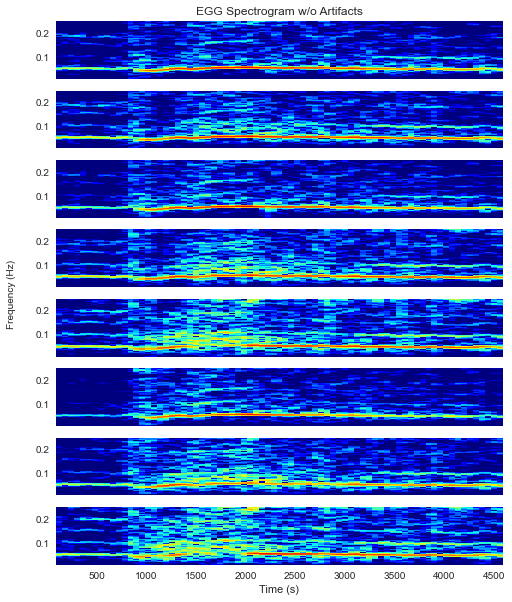

In [10]:
fig, ax = plt.subplots(nrows = dataEGG.shape[1], ncols = 1, figsize=(8,10), sharex=True)
nch = dataEGG.shape[1]
fsEGG = 250

cm = plt.cm.get_cmap('jet')
ax[0].set_title('EGG Spectrogram w/o Artifacts')
ax[nch-1].set_xlabel('Time (s)')
fig.text(0.04, 0.5, 'Frequency (Hz)', va='center', rotation='vertical')
window = int(fsEGG*60*4)
wSize = int(1/.05*fsEGG)
#wSize = 20
wNoise = 15000
artifact = []
removed = []

for ii in range(nch):
    wiener = sp.signal.wiener(dataEGG[:,ii], mysize=wSize, noise=wNoise)
    im = ax[ii].specgram(dataEGG[:,ii]-wiener,NFFT=window,Fs=fsEGG,noverlap=window*.75,interpolation='none',cmap = 'jet')
    artifact.append(np.mean(im[0][im[1]>0.05,:],axis=0))
    removed.append(dataEGG[:,ii]-wiener)
    ax[ii].axis('tight')
    ax[ii].set_ylim([0.01,0.25])
    #ax[ii].set_ylabel('Frequency (Hz)')
    ax[ii].grid(None)
    im[3].set_clim(20,55)

removed = np.array(removed)

plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_2.png')

(20.0, 40.0)

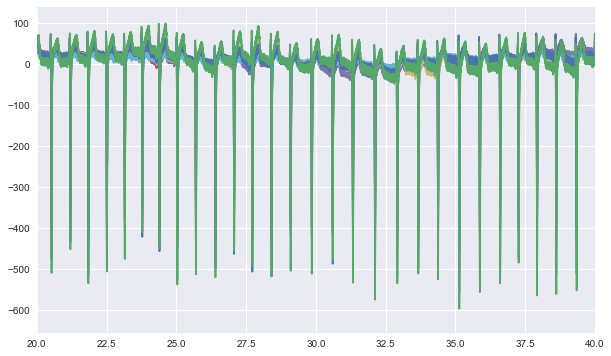

In [11]:
tplot = 250*120
plt.figure(figsize = (10,6))
plt.plot(tEGG[:tplot]-tEGG[0],removed.T[:tplot])
plt.xlim([20,40])


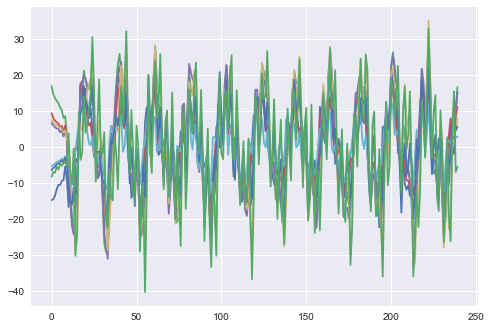

In [12]:
dataEGG_dec = sp.signal.decimate(removed,5)
dataEGG_dec = sp.signal.decimate(dataEGG_dec,5)
dataEGG_dec = sp.signal.decimate(dataEGG_dec,5)
dataEGG_dec = sp.signal.decimate(dataEGG_dec,2)
plt.plot(dataEGG_dec.T[:240])

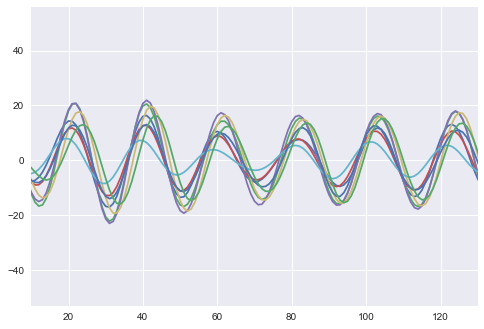

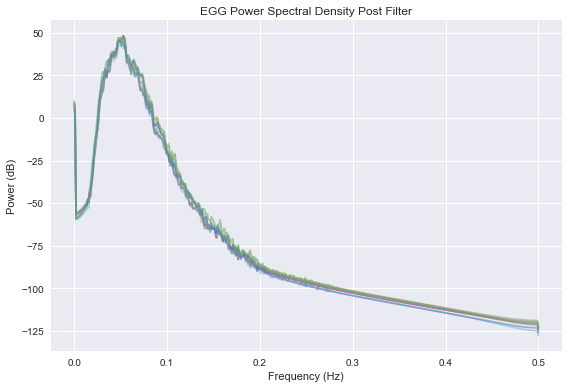

In [13]:
sos = sp.signal.butter(4,[0.03,.07],btype = 'bandpass',fs = 1,output = 'sos')
dataEGG_filt = sp.signal.sosfilt(sos,dataEGG_dec)
dataEGG_filt = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(dataEGG_filt)))
plt.plot(dataEGG_filt.T) #tEGG-tEGG[0],
plt.xlim([10,130])

plt.figure()
for i in range(nch):
  f,Pxx = sp.signal.welch(dataEGG_filt[i],fs = 1,nperseg=1024)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('EGG Power Spectral Density Post Filter')

plt.tight_layout()
plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_3.png')

## EEG Processing

Notes:
- going to try ICA
- for some reason there is edge instability in the filters
- filter to alpha band
- when doing PAC try to make comodulogram
- maybe use sherlock or something with more computational resources

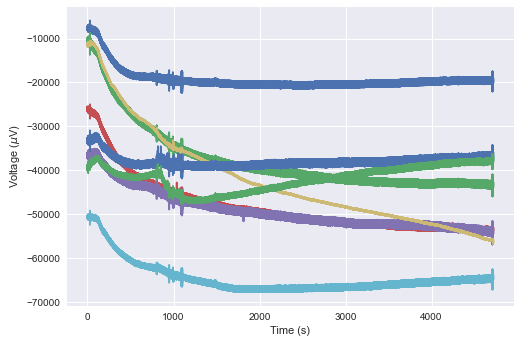

In [14]:
plt.plot(tEEG-tEEG[0],dataEEG)
plt.xlabel('Time (s)')
plt.ylabel(r'Voltage ($\mu$V)')

plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_4.png')

Text(0.5, 1.0, 'Post Filter')

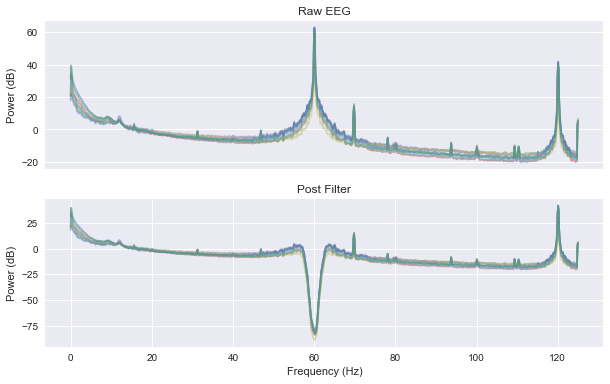

In [15]:
plt.subplots(2,1,figsize = (10,6))
plt.subplot(2,1,1)
for i in range(nch):
  f,Pxx = sp.signal.welch(dataEEG[:,i],fs = 250,nperseg=2048)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.ylabel('Power (dB)')
plt.title('Raw EEG')
plt.xticks([])

plt.subplot(2,1,2)
sos = sp.signal.butter(4,[57,63],btype = 'bandstop',fs = 250,output = 'sos')
dataEEG_notch = sp.signal.sosfilt(sos,dataEEG.T)
dataEEG_notch = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(dataEEG_notch))).T


for i in range(nch):
  f,Pxx = sp.signal.welch(dataEEG_notch[:,i],fs = 250,nperseg=2048)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Post Filter')

Text(0.5, 1.0, 'Post Filter')

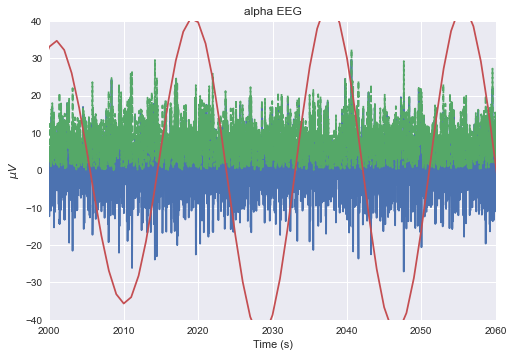

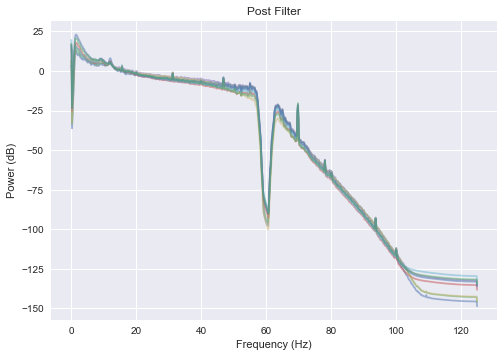

In [16]:
from CFC import *

sos = sp.signal.butter(4,1,btype = 'highpass',fs = 250,output = 'sos')
dataEEG_filt = sp.signal.sosfilt(sos,dataEEG_notch.T)
dataEEG_filt = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(dataEEG_filt)))

'''
plt.figure()
plt.plot(tEEG-tEEG[0],dataEEG_filt.T[:,1])
plt.ylim([-100,100])
plt.xlim([100,110])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')
'''



sos = sp.signal.butter(4,[1,50],btype = 'bandpass',fs = 250,output = 'sos')
dataEEG_filt = sp.signal.sosfilt(sos,dataEEG_filt)
dataEEG_filt = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(dataEEG_filt))).T

plt.figure()
plt.plot(tEEG-tEEG[0],dataEEG_filt[:,1])
plt.plot(tEEG-tEEG[0],np.abs(sp.signal.hilbert(dataEEG_filt[:,1])),ls = '--')
plt.plot(dataEGG_filt[1])
plt.ylim([-40,40])
plt.xlim([2000,2060])
plt.title('alpha EEG')
plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.figure()
for i in range(nch):
  f,Pxx = sp.signal.welch(dataEEG_filt[:,i],fs = 250,nperseg=2048)
  plt.plot(f,10*np.log10(Pxx),alpha = .5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.title('Post Filter')


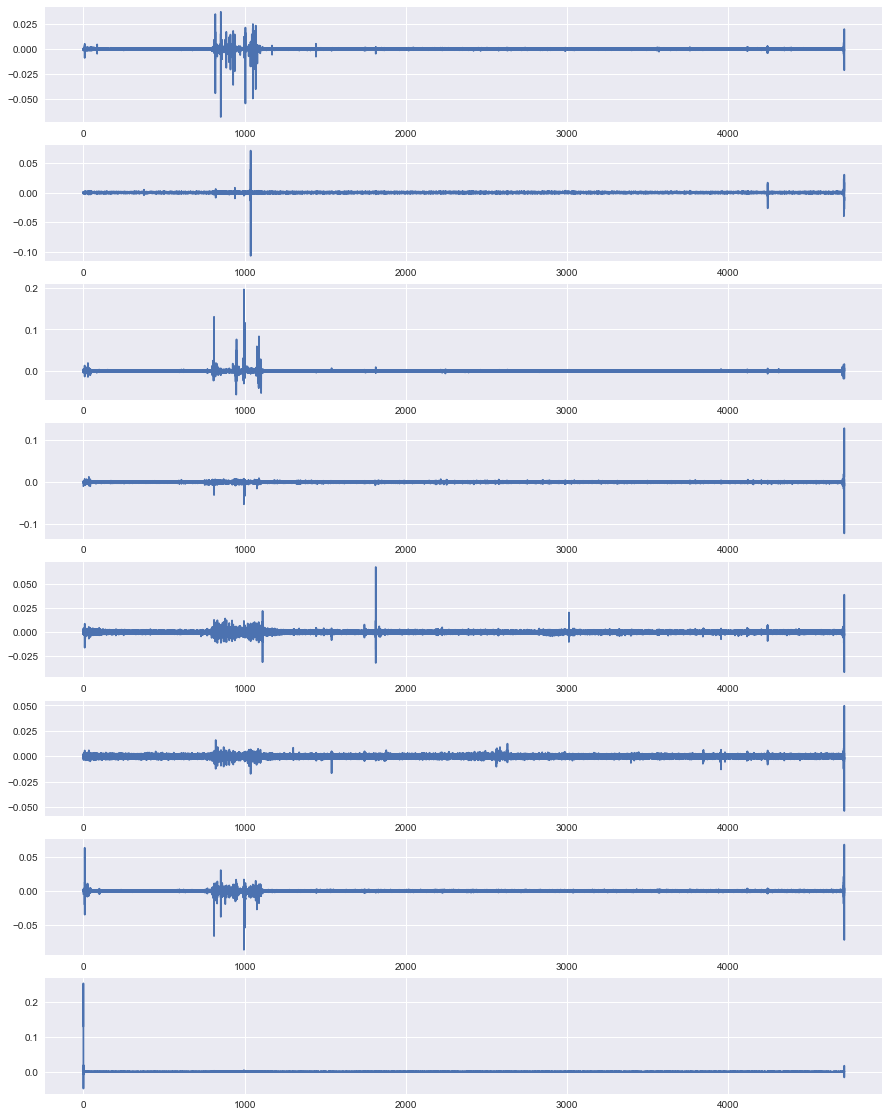

In [17]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=8)
S_ = ica.fit_transform(dataEEG_filt)

plt.subplots(8,1,figsize = (15,20))
for i in range(8):
    plt.subplot(8,1,i+1 )
    plt.plot(tEEG-tEEG[0],S_[:,i])

### Resample the EGG data




(8, 4722)


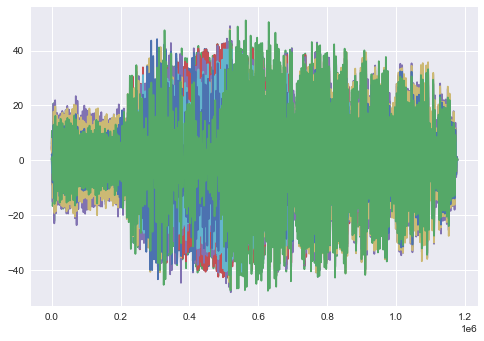

In [18]:
dataEGG_up = np.zeros_like(dataEEG)
print(dataEGG_filt.shape)
for ch in range(nch):
    #print(ch)
    x = np.arange(0,dataEGG_filt.shape[1])
    f = sp.interpolate.interp1d(x,dataEGG_filt[ch])
    xnew = tEEG-tEEG[0]
    dataEGG_up[:,ch] = f(xnew)
    #dataEGG_up[:,ch] = sp.signal.resample(dataEGG_filt[:,ch],dataEGG.shape[0])#,tEGG-tEGG[0])

plt.plot(dataEGG_up)

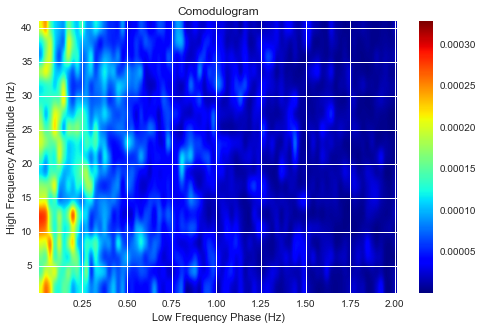

In [19]:
comod, fig, ax, im = comodulogram(removed[1,250*60*20:250*60*40],dataEEG_filt[250*60*20:250*60*40,0],250,lrange = [.01,2],hrange = [1,40], lseg = .05,hseg = 4,order = 2,method = 'MI',plot = True)

plt.xlabel('Low Frequency Phase (Hz)')
plt.ylabel('High Frequency Amplitude (Hz)')
plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_5.png')

In [20]:

'''
fig, ax = plt.subplots(figsize = (8,5)) #feel free to change figsize
im = ax.imshow(comod,origin = 'lower',extent = [.01,2+.02,1,44],aspect = 'auto',interpolation = 'gaussian',cmap = 'jet')

ax.set_ylabel('High Frequency Amplitude (Hz)')
ax.set_xlabel('Low Frequency Phase (Hz)')
ax.set_title('Comodulogram')
fig.colorbar(im)
'''

"\nfig, ax = plt.subplots(figsize = (8,5)) #feel free to change figsize\nim = ax.imshow(comod,origin = 'lower',extent = [.01,2+.02,1,44],aspect = 'auto',interpolation = 'gaussian',cmap = 'jet')\n\nax.set_ylabel('High Frequency Amplitude (Hz)')\nax.set_xlabel('Low Frequency Phase (Hz)')\nax.set_title('Comodulogram')\nfig.colorbar(im)\n"

In [21]:
def time_resolved_MI(lsig,hsig,nperseg = 20,noverlap = 10):

    total_size = np.min([lsig.size,hsig.size])
    if noverlap >= nperseg:
        ValueError('noverlap must be less than nperseg')

    shift = nperseg-noverlap
    N = int(total_size//shift)- int(np.ceil(noverlap/shift))
    trMI = np.zeros((N,))
    for i in range(N):
        trMI[i],_,_ = calc_MI(lsig[i*shift:i*shift+nperseg],hsig[i*shift:i*shift+nperseg])
    
    return trMI

sos = sp.signal.butter(4,[8,12],btype = 'bandpass',fs = 250,output = 'sos')
alpha_band_EEG = sp.signal.sosfilt(sos,dataEEG_filt.T)
alpha_band_EEG = np.fliplr(sp.signal.sosfilt(sos,np.fliplr(alpha_band_EEG))).T

trMI = time_resolved_MI(dataEGG_up[:,1],alpha_band_EEG[:,0],120*250,90*250)    


(0.0, 0.02)

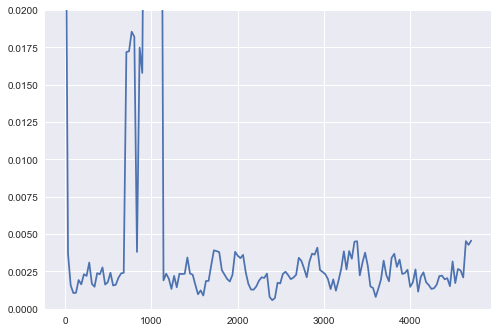

In [22]:
tMI = np.linspace(0,dataEEG.shape[0]/250,trMI.size)
plt.plot(tMI,trMI)
plt.ylim([0,.02])

(-20.0, 20.0)

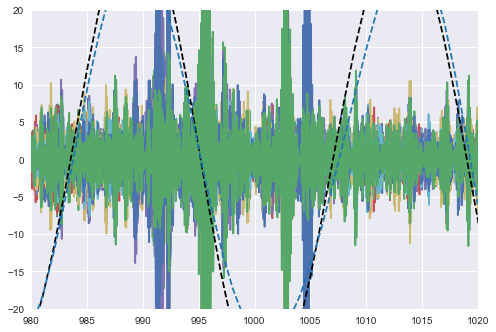

In [23]:
plt.plot(tEEG-tEEG[0],alpha_band_EEG)
plt.plot(dataEGG_filt[1],ls = '--',c = 'k')
plt.plot(tEEG-tEEG[0],dataEGG_up[:,0],ls = '--',c = 'tab:blue')
plt.xlim([980,1020])
plt.ylim([-20,20])

In [24]:
dataEGG_up.shape

(1178256, 8)

In [25]:
np.mean(np.diff(tMI))

30.804078431372552

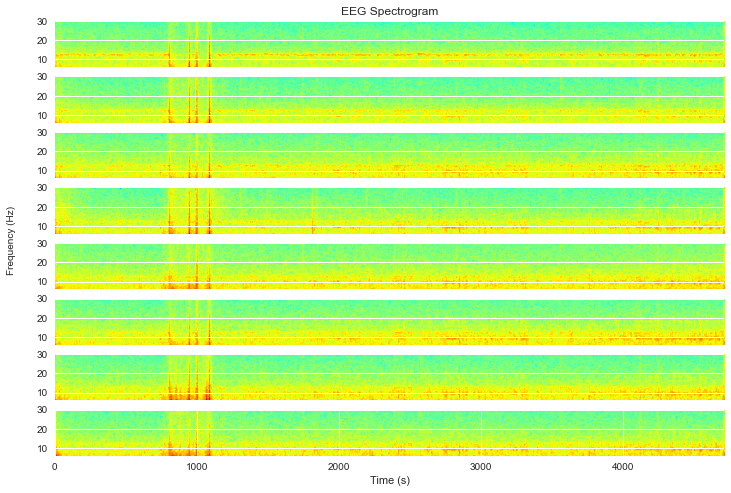

In [26]:
fig,ax = plt.subplots(8,1,figsize = (12,8))
ax[0].set_title('EEG Spectrogram')
ax[nch-1].set_xlabel('Time (s)')
fig.text(0.07, 0.5, 'Frequency (Hz)', va='center', rotation='vertical')

for i in range(8):
    f,t,Sxx = sp.signal.spectrogram(dataEEG_filt[:,i],fs = 250,nperseg = 512,noverlap=512/4)
    im = ax[i].imshow(10*np.log10(Sxx),origin = 'lower',extent = [0,t[-1],0,f[-1]],aspect = 'auto',interpolation = 'gaussian',cmap = 'jet')
    im.set_clim([-40,25])
    #plt.colorbar()
    ax[i].set_ylim([6,30])
    if i != nch-1:
        ax[i].set_xticks([])

plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_6.png')

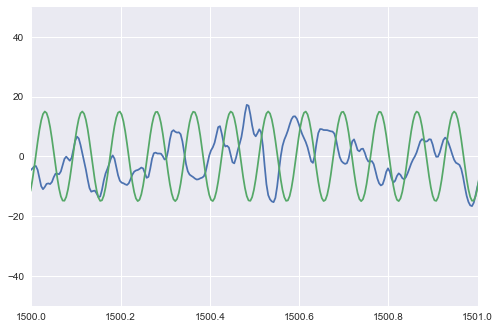

In [27]:
plt.plot(tEEG-tEEG[0],dataEEG_filt[:,0])
plt.ylim([-50,50])
plt.xlim([1500,1501])

plt.plot(tEEG-tEEG[0],15*np.sin(2*np.pi*12*tEEG-tEEG[0]))

pb = 0.6461111903190613, pa = 0.0050508868880569935
RanksumsResult(statistic=-1.342610744212731, pvalue=0.1793980495050551)
[0.002035468542698139, 0.00238725410246377]
[0.00011543651074910307, 0.00019030506747439723]


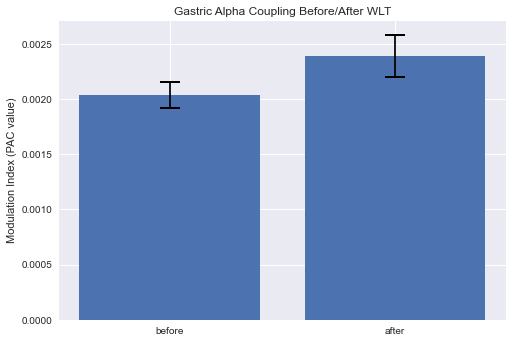

In [28]:
beforeidx = np.where(((tMI > 100) & (tMI < 700)))
afteridx = np.where((tMI > 1200))
_,pb = sp.stats.shapiro(trMI[beforeidx])
_,pa = sp.stats.shapiro(trMI[afteridx])
print(f'pb = {pb}, pa = {pa}')
if (pb < .05) or (pa < .05):
    results = sp.stats.ranksums(trMI[beforeidx],trMI[afteridx])
else:
    results = sp.stats.ttest_ind(trMI[beforeidx],trMI[afteridx])
print(results)

means = [np.mean(trMI[beforeidx]),np.mean(trMI[afteridx])]
errors = [sp.stats.sem(trMI[beforeidx]),sp.stats.sem(trMI[afteridx]*2.2)]
plt.bar([0,1],means,yerr = errors,capsize=10,error_kw={'markeredgewidth':2} )
plt.xticks([0,1],['before','after'])
plt.title('Gastric Alpha Coupling Before/After WLT')
plt.ylabel('Modulation Index (PAC value)')

plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/03/fig_7.png')

# print mean values and errors
print(means) # array: [before, after]
print(errors) # array: [before, after]

### Test Code

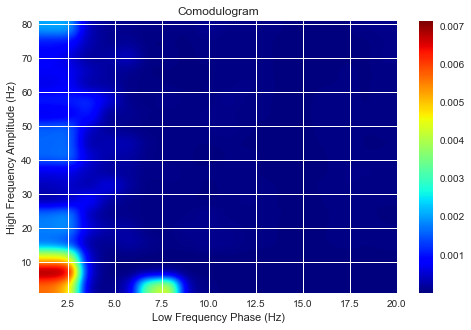

In [29]:
def generate_coupled_EEG_sig(time, flow,fhigh, coupling_coefficient,noise_var = 0):
  #time = np.linspace(0,100,10001)

  slow_waveform = np.cos(2*np.pi*flow*time)
  # this will allow the amplitude to vary from a minumum of 1-coupling 
  # coefficient to a maximum of 1.0 at the same frequency as the flow signal

  amplitude_slow = (coupling_coefficient*slow_waveform + 2.0-coupling_coefficient)/2

  noise = np.random.normal(0,np.sqrt(noise_var),time.size)
  fast_waveform = amplitude_slow * np.cos(2*np.pi*fhigh*time) 
  signal = fast_waveform + slow_waveform + noise

  return signal

t = np.arange(0,20,1/250)
signal = generate_coupled_EEG_sig(t,2,10,.5,.1)
comod, fig, ax, im = comodulogram(signal,signal,250,lrange = [1,20],hrange = [1,80], lseg = 2,hseg = 8,order = 2,method = 'MI',plot = True)

#plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/fig_test_1.png')
  

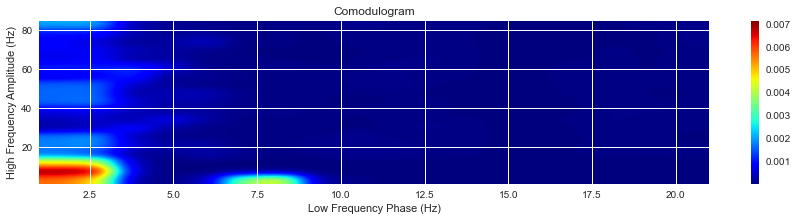

In [30]:
fig, ax = plt.subplots(figsize = (15,3)) #feel free to change figsize
im = ax.imshow(comod,origin = 'lower',extent = [1,21,1,85],aspect = 'auto',interpolation = 'gaussian',cmap = 'jet')

ax.set_ylabel('High Frequency Amplitude (Hz)')
ax.set_xlabel('Low Frequency Phase (Hz)')
ax.set_title('Comodulogram')
fig.colorbar(im)

#plt.savefig('/Users/irawadee.t/Desktop/research 2022/real_data/figures/fig_test_2.png')